# LAB 4: Quantization


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cpu')

## Get the dataset

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:01<00:00, 86145892.19it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Model Declaration

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.fc3 = nn.Linear(84, 10, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

## Training

In [5]:
from torch.utils.data import DataLoader

def train(model: nn.Module, dataloader: DataLoader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

def test(model: nn.Module, dataloader: DataLoader, max_samples=None) -> float:
    correct = 0
    total = 0
    n_inferences = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)


            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if max_samples:
                n_inferences += images.shape[0]
                if n_inferences > max_samples:
                    break

    return 100 * correct / total

In [6]:
train(net, trainloader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[1,  2000] loss: 2.242
[1,  4000] loss: 1.916
[1,  6000] loss: 1.725
[1,  8000] loss: 1.657
[1, 10000] loss: 1.573
[1, 12000] loss: 1.520
[2,  2000] loss: 1.464
[2,  4000] loss: 1.427
[2,  6000] loss: 1.418
[2,  8000] loss: 1.400
[2, 10000] loss: 1.380
[2, 12000] loss: 1.356
Finished Training


In [7]:
score = test(net, testloader)
print('Accuracy of the network on the test images: {}%'.format(score))

Accuracy of the network on the test images: 53.05%


## Visualization of weights distribution

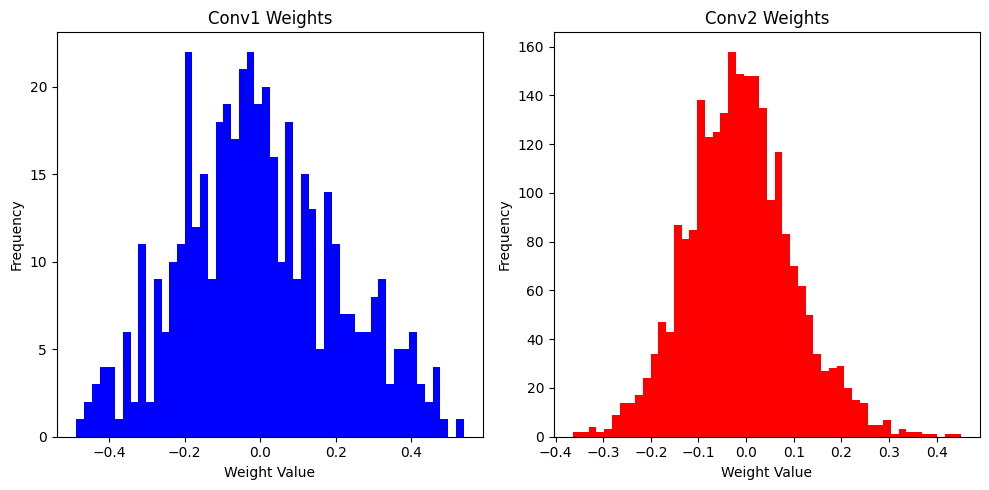

Conv1 :
  mean        :  -0.0016882448690012097
  sigma       :  0.20623211562633514
  range       :  [-0.4862585663795471, 0.5380329489707947]
  3sigma range:  [-0.6203845917480066, 0.6170081020100042]
Conv2 :
  mean        :  -0.012305649928748608
  sigma       :  0.11049314588308334
  range       :  [-0.3630130887031555, 0.4504624605178833]
  3sigma range:  [-0.34378508757799864, 0.3191737877205014]


In [8]:
# ADD YOUR CODE HERE to plot distributions of weights

# You can get a flattened vector of the weights of fc1 like this:
#   fc1_weights = net.fc1.weight.data.cpu().view(-1)

import matplotlib.pyplot as plt

# Get the flattened vector of weights of conv1 and conv2
conv1_weights = net.conv1.weight.data.cpu().view(-1)
conv2_weights = net.conv2.weight.data.cpu().view(-1)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the weights of conv1
ax1.hist(conv1_weights, bins=50, color='blue')
ax1.set_title('Conv1 Weights')
ax1.set_xlabel('Weight Value')
ax1.set_ylabel('Frequency')

# Plot the weights of conv2
ax2.hist(conv2_weights, bins=50, color='red')
ax2.set_title('Conv2 Weights')
ax2.set_xlabel('Weight Value')
ax2.set_ylabel('Frequency')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

conv1_range = [torch.min(conv1_weights).item(), torch.max(conv1_weights).item()]
conv1_sigma = torch.std(conv1_weights).item()
conv1_mean = torch.mean(conv1_weights).item()

conv1_3sigma_range = [conv1_mean - 3 * conv1_sigma, conv1_mean + 3 * conv1_sigma]

conv2_range = [torch.min(conv2_weights).item(), torch.max(conv2_weights).item()]
conv2_sigma = torch.std(conv2_weights).item()
conv2_mean = torch.mean(conv2_weights).item()

conv2_3sigma_range = [conv2_mean - 3 * conv2_sigma, conv2_mean + 3 * conv2_sigma]

print('Conv1 :')
print('  mean        : ', conv1_mean)
print('  sigma       : ', conv1_sigma)
print('  range       : ', conv1_range)
print('  3sigma range: ', conv1_3sigma_range)


print('Conv2 :')
print('  mean        : ', conv2_mean)
print('  sigma       : ', conv2_sigma)
print('  range       : ', conv2_range)
print('  3sigma range: ', conv2_3sigma_range)




## Post training quantization: Weights

In [9]:
from copy import deepcopy

# A convenience function which we use to copy CNNs
def copy_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)
    if hasattr(model, 'input_activations'):
        result.input_activations = deepcopy(model.input_activations)

    for result_layer, original_layer in zip(result.children(), model.children()):
        if isinstance(result_layer, nn.Conv2d) or isinstance(result_layer, nn.Linear):
            if hasattr(original_layer.weight, 'scale'):
                result_layer.weight.scale = deepcopy(original_layer.weight.scale)
            if hasattr(original_layer, 'activations'):
                result_layer.activations = deepcopy(original_layer.activations)
            if hasattr(original_layer, 'output_scale'):
                result_layer.output_scale = deepcopy(original_layer.output_scale)

    return result

In [10]:
from typing import Tuple

def quantized_weights(weights: torch.Tensor, target_range: float = 127.0) -> Tuple[torch.Tensor, float]:
    '''
    Quantize the weights so that all values are integers between -128 and 127.
    You may want to use the total range, 3-sigma range, or some other range when
    deciding just what factors to scale the float32 values by.

    Parameters:
    weights (Tensor): The unquantized weights
    target_range (float): The desired range for the quantized values. Default is 127.0.

    Returns:
    (Tensor, float): A tuple with the following elements:
                        * The weights in quantized form, where every value is an integer between -128 and 127.
                          The "dtype" will still be "float", but the values themselves should all be integers.
                        * The scaling factor that your weights were multiplied by.
                          This value does not need to be an 8-bit integer.
    '''

    #ADD YOUR CODE HERE
    mu = torch.mean(weights)
    min = mu -target_range
    max = mu + target_range

    weights = torch.clamp(weights,min=min,max=max)

    scale = 127 / (torch.maximum(torch.abs(min),torch.abs(max)))
    weights *= scale
    weights = torch.floor(weights)
    return weights, scale

In [11]:
net_q2 = copy_model(net)

In [12]:
def quantize_layer_weights(model: nn.Module):
    for layer in model.children():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            q_layer_data, scale = quantized_weights(layer.weight.data, 3*net.fc3.weight.data.cpu().view(-1).std())
            q_layer_data = q_layer_data.to(device)

            layer.weight.data = q_layer_data
            layer.weight.scale = scale

            if (q_layer_data < -128).any() or (q_layer_data > 127).any():
                raise Exception("Quantized weights of {} layer include values out of bounds for an 8-bit signed integer".format(layer.__class__.__name__))
            if (q_layer_data != q_layer_data.round()).any():
                raise Exception("Quantized weights of {} layer include non-integer values".format(layer.__class__.__name__))

quantize_layer_weights(net_q2)

In [13]:
score = test(net_q2, testloader)
print('Accuracy of the network after quantizing all weights: {}%'.format(score))

Accuracy of the network after quantizing all weights: 52.22%


In [14]:
## Print the size of the model
## ADD YOUR CODE HERE

model = net_q2
size_model = 0
for param in model.parameters():
    if param.data.is_floating_point():
        size_model += param.numel() * torch.finfo(param.data.dtype).bits
    else:
        size_model += param.numel() * torch.iinfo(param.data.dtype).bits
print(f"model size: {size_model} / bit | {size_model / 8e6:.2f} / MB")

model size: 1976640 / bit | 0.25 / MB


## Quantization activations

In [15]:
def register_activation_profiling_hooks(model: Net):
    model.input_activations = np.empty(0)
    model.conv1.activations = np.empty(0)
    model.conv2.activations = np.empty(0)
    model.fc1.activations = np.empty(0)
    model.fc2.activations = np.empty(0)
    model.fc3.activations = np.empty(0)

    model.profile_activations = True

    def conv1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.input_activations = np.append(model.input_activations, x[0].cpu().view(-1))
    model.conv1.register_forward_hook(conv1_activations_hook)

    def conv2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv1.activations = np.append(model.conv1.activations, x[0].cpu().view(-1))
    model.conv2.register_forward_hook(conv2_activations_hook)

    def fc1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv2.activations = np.append(model.conv2.activations, x[0].cpu().view(-1))
    model.fc1.register_forward_hook(fc1_activations_hook)

    def fc2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc1.activations = np.append(model.fc1.activations, x[0].cpu().view(-1))
    model.fc2.register_forward_hook(fc2_activations_hook)

    def fc3_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc2.activations = np.append(model.fc2.activations, x[0].cpu().view(-1))
            model.fc3.activations = np.append(model.fc3.activations, y[0].cpu().view(-1))
    model.fc3.register_forward_hook(fc3_activations_hook)


In [16]:
net_q3 = copy_model(net)
register_activation_profiling_hooks(net_q3)

# Run through the training dataset again while profiling the input and output activations this time
# We don't actually have to perform gradient descent for this, so we can use the "test" function
test(net_q3, trainloader, max_samples=400)
net_q3.profile_activations = False

### Visualize activation distribution

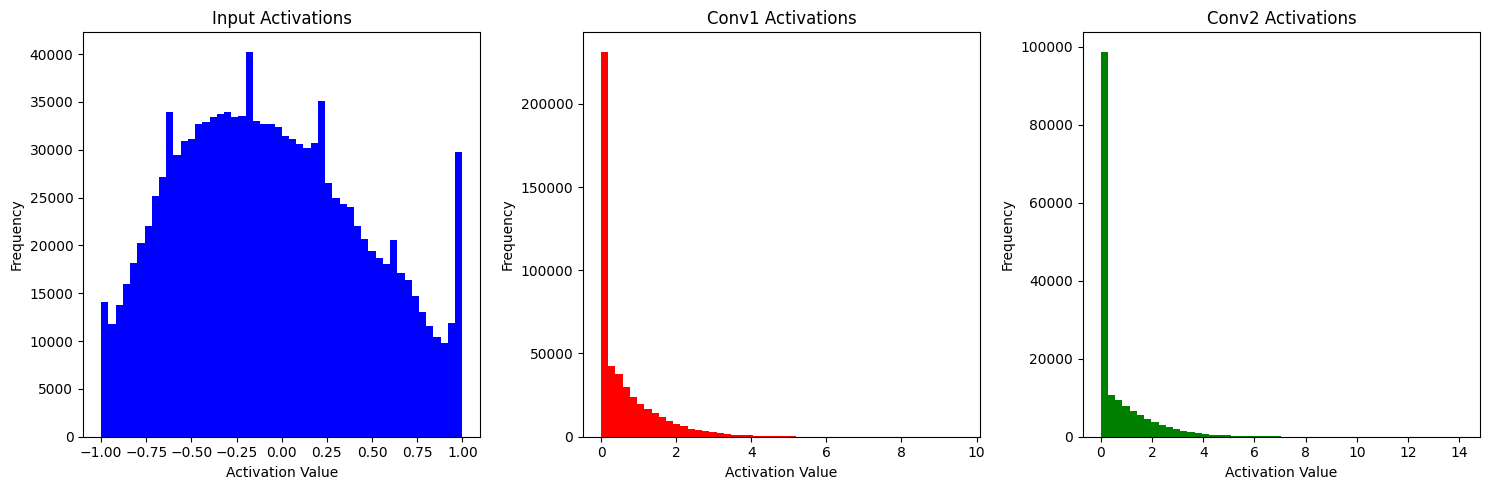

Input :
  mean        :  -0.058839406750146483
  sigma       :  0.503377404145554
  range       :  [-1.0, 1.0]
  3sigma range:  [-2.6483152430395, 3.9234441787081042]
Conv1 :
  mean        :  0.5890977563168389
  sigma       :  0.8505761775761336
  range       :  [0.0, 9.61680793762207]
  3sigma range:  [-1.9626307764115618, 3.14082628904524]
Conv2 :
  mean        :  0.6375644678343021
  sigma       :  1.095293236957934
  range       :  [0.0, 14.107772827148438]
  3sigma range:  [-2.6483152430395, 3.9234441787081042]


In [20]:
# ADD YOUR CODE HERE: to plot activation distribution
# You can access the activation matrice like this:
# net_q3.input_activations
# net_q3.conv1_activations
# ....

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot the input activations
ax1.hist(net_q3.input_activations, bins=50, color='blue')
ax1.set_title('Input Activations')
ax1.set_xlabel('Activation Value')
ax1.set_ylabel('Frequency')

# Plot the activations of conv1
ax2.hist(net_q3.conv1.activations, bins=50, color='red')
ax2.set_title('Conv1 Activations')
ax2.set_xlabel('Activation Value')
ax2.set_ylabel('Frequency')

# Plot the activations of conv2
ax3.hist(net_q3.conv2.activations, bins=50, color='green')
ax3.set_title('Conv2 Activations')
ax3.set_xlabel('Activation Value')
ax3.set_ylabel('Frequency')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


if isinstance(net_q3.input_activations,np.ndarray):
  input_activations = torch.from_numpy(net_q3.input_activations)

if isinstance(net_q3.conv1.activations,np.ndarray):
  conv1_activations = torch.from_numpy(net_q3.conv1.activations)

if isinstance(net_q3.conv2.activations,np.ndarray):
  conv2_activations = torch.from_numpy(net_q3.conv2.activations)

nq3_input_range = [torch.min(input_activations).item(), torch.max(input_activations).item()]
nq3_input_sigma = torch.std(input_activations).item()
nq3_input_mean = torch.mean(input_activations).item()

nq3_conv2_3sigma_range = [nq3_input_mean - 3 * nq3_input_sigma, nq3_input_mean + 3 * nq3_input_sigma]

nq3_conv1_range = [torch.min(conv1_activations).item(), torch.max(conv1_activations).item()]
nq3_conv1_sigma = torch.std(conv1_activations).item()
nq3_conv1_mean = torch.mean(conv1_activations).item()

nq3_conv1_3sigma_range = [nq3_conv1_mean - 3 * nq3_conv1_sigma, nq3_conv1_mean + 3 * nq3_conv1_sigma]

nq3_conv2_range = [torch.min(conv2_activations).item(), torch.max(conv2_activations).item()]
nq3_conv2_sigma = torch.std(conv2_activations).item()
nq3_conv2_mean = torch.mean(conv2_activations).item()

nq3_conv2_3sigma_range = [nq3_conv2_mean - 3 * nq3_conv2_sigma, nq3_conv2_mean + 3 * nq3_conv2_sigma]

print('Input :')
print('  mean        : ', nq3_input_mean)
print('  sigma       : ', nq3_input_sigma)
print('  range       : ', nq3_input_range)
print('  3sigma range: ', nq3_conv2_3sigma_range)


print('Conv1 :')
print('  mean        : ', nq3_conv1_mean)
print('  sigma       : ', nq3_conv1_sigma)
print('  range       : ', nq3_conv1_range)
print('  3sigma range: ', nq3_conv1_3sigma_range)


print('Conv2 :')
print('  mean        : ', nq3_conv2_mean)
print('  sigma       : ', nq3_conv2_sigma)
print('  range       : ', nq3_conv2_range)
print('  3sigma range: ', nq3_conv2_3sigma_range)

### Quantize activations

In [21]:
from typing import List

class NetQuantized(nn.Module):
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantized, self).__init__()

        net_init = copy_model(net_with_weights_quantized)

        self.conv1 = net_init.conv1
        self.pool = net_init.pool
        self.conv2 = net_init.conv2
        self.fc1 = net_init.fc1
        self.fc2 = net_init.fc2
        self.fc3 = net_init.fc3

        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            def pre_hook(l, x):
                x = x[0]
                if (x < -128).any() or (x > 127).any():
                    raise Exception("Input to {} layer is out of bounds for an 8-bit signed integer".format(l.__class__.__name__))
                if (x != x.round()).any():
                    raise Exception("Input to {} layer has non-integer values".format(l.__class__.__name__))

            layer.register_forward_pre_hook(pre_hook)

        # Calculate the scaling factor for the initial input to the CNN
        self.input_activations = net_with_weights_quantized.input_activations
        self.input_scale = NetQuantized.quantize_initial_input(self.input_activations)

        # Calculate the output scaling factors for all the layers of the CNN
        preceding_layer_scales = []
        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            layer.output_scale = NetQuantized.quantize_activations(layer.activations, layer.weight.scale, self.input_scale, preceding_layer_scales)
            preceding_layer_scales.append((layer.weight.scale, layer.output_scale))

    @staticmethod
    def quantize_initial_input(initial_input: np.ndarray) -> float:
        '''
        Calculate a scaling factor for the images that are input to the first layer of the CNN.

        Parameters:
        initial_input (ndarray): The values of all the pixels which were part of the input image during training

        Returns:
        float: A scaling factor that the input should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''

        # ADD your code here
        if isinstance(initial_input,np.ndarray):
          initial_input = torch.from_numpy(initial_input)
        min = torch.min(initial_input)
        max = torch.max(initial_input)
        scale = 127. / torch.max(torch.abs(max),torch.abs(min))

        return scale

    @staticmethod
    def quantize_activations(activations: np.ndarray, s_w: float, s_initial_input: float, ns: List[Tuple[float, float]]) -> float:
        '''
        Calculate a scaling factor to multiply the output of a layer by.

        Parameters:
        activations (ndarray): The values of all the pixels which have been output by this layer during training
        s_w (float): The scale by which the weights of this layer were multiplied as part of the "quantize_weights" function you wrote earlier
        s_initial_input (float): The scale by which the initial input to the neural network was multiplied
        ns ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        float: A scaling factor that the layer output should be multiplied by before being fed into the next layer.
               This value does not need to be an 8-bit integer.
        '''
        # ADD YOUR CODE HERE
        if isinstance(activations,np.ndarray):
          activations = torch.from_numpy(activations)
        min = torch.min(activations)
        max = torch.max(activations)
        scale = 127. / torch.max(torch.abs(max),torch.abs(min))

        inv_scale = s_w * s_initial_input

        for prevous_sw,previous_so in ns:
          inv_scale *= prevous_sw * previous_so

        return scale / inv_scale

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # You can access the output activation scales like this:
        #   fc1_output_scale = self.fc1.output_scale
        # You don't need to quantize Relu outputs

        # ADD YOUR CODE HERE (Replace the ...)
        x *= self.input_scale
        x = torch.floor(x)

        x = self.conv1(x)
        x *= self.conv1.output_scale
        x = torch.floor(x)
        x = self.pool(F.relu(x))
        x = torch.clamp(x, min=-128, max=127)

        x = self.conv2(x)
        x *= self.conv2.output_scale
        x = torch.floor(x)

        x = self.pool(F.relu(x))
        x = torch.clamp(x, min=-128, max=127)
        x = x.view(-1, 16 * 5 * 5)

        x = self.fc1(x)
        x *= self.fc1.output_scale
        x = torch.floor(x)
        x = F.relu(x)
        x = torch.clamp(x, min=-128, max=127)

        x = self.fc2(x)
        x *= self.fc2.output_scale
        x = torch.floor(x)
        x = F.relu(x)
        x = torch.clamp(x, min=-128, max=127)

        x = self.fc3(x)
        x *= self.fc3.output_scale
        # ...

        return x

In [22]:
# Merge the information from net_q2 and net_q3 together

net_init = copy_model(net_q2)
net_init.input_activations = deepcopy(net_q3.input_activations)
for layer_init, layer_q3 in zip(net_init.children(), net_q3.children()):
    if isinstance(layer_init, nn.Conv2d) or isinstance(layer_init, nn.Linear):
        layer_init.activations = deepcopy(layer_q3.activations)

net_quantized = NetQuantized(net_init)

In [23]:
score = test(net_quantized, testloader)
print('Accuracy of the network after quantizing both weights and activations: {}%'.format(score))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of the network after quantizing both weights and activations: 52.18%
